# NISQ simulation with QuTiP

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi
from qutip.qip.device import Processor, RandomNoise
from qutip import sigmaz, sigmay, sigmax, destroy, basis, fidelity, Bloch
from qutip.qip import rx, ry, rz, hadamard_transform

The simulation of quantum information processing is based on the QuTiP Lindbladian equation solver. The common way of simulating quantum information processing is by gate matrix production, this mothod is included in the class `qutit.qip.QubitCircuit`. The simulation introduced here, is different as it simulates the dynamics of the qubits under the driving Hamiltonian. Its closer to the physical realization than the common approach and more convenient when simulating noise based on physical hadwares. The simulator, under the name of `qutip.qip.device.Porcessor`, simulates general quantum devices for noisy quantum computing. This example contains the most essential part of the quantum device simulator, i.e. the noisy evolution under given control pulse. Gate decomposition for specific hardware realization can be found in the corresponding subclasses.

## The 3 main ingredients for unitary evolution

### Controling single qubit
The simulation of a unitary evolution with `Porcessor` needs at least 3 ingredients: the control Hamiltonian $H_i$, the pulse intensity $c_i$ and the time $t$. The evolution is given by 

\begin{equation}
U(t)=\exp(-\mathrm{i} \sum_j c_j H_j t)
\end{equation}

The `Porcessor`, as a simulator of a quantum device, is defined by a list of Hamiltonians, i.e. the control pulse driving the evolution. In this example, we define a single-qubit quantum device with $\sigma_z$ and $\sigma_y$ pulse.

In [2]:
processor = Processor(N=1)
processor.add_ctrl(sigmaz(), targets=0)
processor.add_ctrl(sigmay(), targets=0)
[ctrl for ctrl in processor.ctrls]

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]]]

The pulse intensity and time for each pulse are saved in the attributes `coeff`, a 2-d NumPy array, and `tlist`, a 1-d NumPy array. `tlist` specifies the start and the end of each pulse, and thus is one element longer the `coeff`. (This is different from the usual requirement in QuTiP solver where `tlist` and `coeff` needs to have the same length.) The definition below means that we turn on $\sigma_y$ pulse for $t=\pi$, with intensity 0.5

In [3]:
processor.coeffs = np.array([[ 0. ],
                            [ 0.5]])
processor.tlist = np.array([0., pi])

This pulse is a $\pi$ pulse that flip the qubit from $\left |0 \right\rangle$ to $\left |1 \right\rangle$, equvilent to a rotation around y-axis of angle $\pi$:

$$R_y(\theta) = \begin{pmatrix} cos(\theta/2) & -sin(\theta/2) \\ sin(\theta/2) & cos(\theta/2) \end{pmatrix}$$

We can run the simulation to see the result of the evolution starting from $\left |0 \right\rangle$:

In [4]:
basis0 = basis(2, 0)
result = processor.run_state(rho0=basis0)
result.states[-1]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-5.68814159e-07]
 [ 1.00000000e+00]]

As arbitrary single-qubit gate can be decomposed into $R_z(\theta_1) \cdot R_y(\theta_2) \cdot R_z(\theta_3)$, it is enough to use three pulses. For demonstration purpose we choose a $\theta_1=\theta_2=\theta_3=\pi/2$

In [5]:
processor.coeffs = np.array([[ 0.5, 0.,  0.5],
                            [ 0. , 0.5, 0. ]])
processor.tlist = np.array([0., pi/2., 2*pi/2, 3*pi/2])

In [6]:
result = processor.run_state(rho0=basis(2, 1))
result.states[-1].tidyup(1.0e-5) 

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

### Pulse with continuous amplitude
If your pulse intensity is generated some where else and is a distritization of a continuous function, you can also tell the processor two use them with cubic spline.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x269995e7748>)

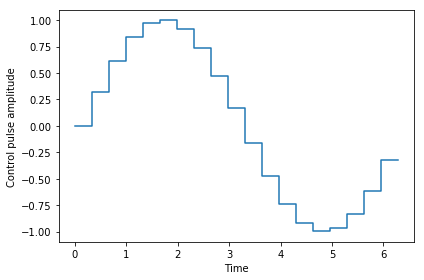

In [7]:
tlist = np.linspace(0., 2*np.pi, 20)
processor = Processor(N=1, spline_type="step_func")
processor.add_ctrl(sigmaz())
processor.tlist = tlist
processor.coeffs = np.array([[np.sin(t) for t in tlist]])
processor.plot_pulses(noisy=False)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2699989db70>)

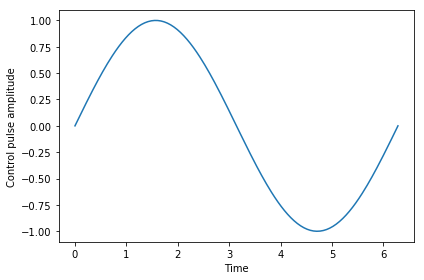

In [8]:
tlist = np.linspace(0., 2*np.pi, 20)
processor = Processor(N=1, spline_type="cubic")
processor.add_ctrl(sigmaz())
processor.tlist = tlist
processor.coeffs = np.array([[np.sin(t) for t in tlist]])
processor.plot_pulses(noisy=False)

## Noisy evolution

`Processor` as a circuit simulator, is different from the common simulator of quantum information processing, as it simulates the dynamics of the qubits under the driving Hamiltonian. Therefore, the noise defined for it is also closer to physical implementation.

### Decoherence

In `Processor`, decoherence noise is simulated by adding collapse operator into the Lindbladian equation. This approach is equivalent to apply random bit flip and phase flip error after applying the quantum gate, but more physical, and is valid even if the gate time is not much shorter than the decay time. For qubit relaxation, one can simply specify the $T_1$ and $T_2$ time for the device or each qubit. Here we assume the qubit system have a drift Hamiltonian $H_d=\hbar \omega \sigma_z$, for simplicity we let $\hbar \omega = 10$

In [9]:
a = destroy(2)
Hadamard = hadamard_transform(1)
initial_state = basis(2,1)
plus_state = (basis(2,1) + basis(2,0)).unit()
tlist = np.arange(0.00, 2.02, 0.02)
H_d = 10.*sigmaz()

#### $T_1$
The $T_1$ relaxation time describes the strength of amplitude damping and can be described, in a two-level system, by a collapse operator $\frac{1}{\sqrt{T_1}}a$, where $a$ is the annihilation operator. This leads to an exponential decay of the population at the excited state proportional to $\exp({-t/T_1})$. This amplitude damping can be simulated by given specify the attribute `t1` of the processor

In [10]:
t1 = 1.
processor = Processor(1, t1=t1)
processor.tlist = tlist
result = processor.run_state(rho0=initial_state, e_ops=[a.dag()*a])

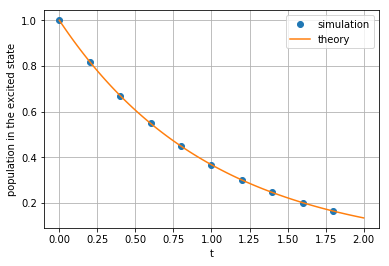

In [11]:
fig, ax = plt.subplots()
ax.plot(tlist[0: 100: 10], result.expect[0][0: 100: 10], 'o', label="simulation")
ax.plot(tlist, np.exp(-1./t1*tlist), label="theory")
ax.set_xlabel("t")
ax.set_ylabel("population in the excited state")
ax.legend()
plt.grid()

#### $T_2$
The $T_2$ time describes the dephasing process. Here one has to be careful that the amplitude damping channel characterized by $T_1$ will also lead to a dephasing proportional to $\exp(-t/2T_1)$. To make sure that the overall phase dampling is $exp(-t/T_2)$, the processor (internally) uses an collapse operator $\frac{1}{\sqrt{2*T'_2}} \sigma_z$ with $\frac{1}{T'_2}+\frac{1}{2T_1}=\frac{1}{T_2}$ to simulate the dephasing. (This also indicates that $T_2 \leqslant 2T_1$)

Usually, the $T_2$ time is measured by the Ramsey experiment, where the qubit starts from the excited state, undergoes a $\pi/2$ pulse, proceeds for a time $t$, and measured after another $\pi/2$ pulse. For simplicity, here we directly calculate the expectation value of $\rm{H}\circ a^\dagger a \circ\rm{H}$, where $\rm{H}$ denotes the Hadamard transformation. This is equivalent to measure the population of $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. The envelope should follow an exponential decay characterized by $T_2$.

In [12]:
t1 = 1. 
t2 = 0.5
processor = Processor(1, t1=t1, t2=t2)
processor.add_ctrl(H_d)
processor.coeffs = np.ones((1,len(tlist)))
processor.tlist= tlist
result = processor.run_state(rho0=plus_state, e_ops=[Hadamard*a.dag()*a*Hadamard])

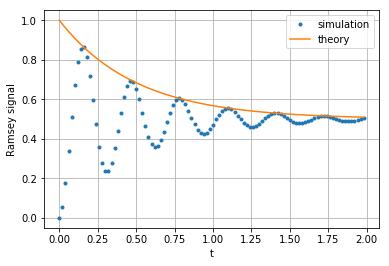

In [13]:
fig, ax = plt.subplots()
# detail about lenght of tlist needs to be fixed
ax.plot(tlist[:-1], result.expect[0][:-1], '.', label="simulation")
ax.plot(tlist[:-1], np.exp(-1./t2*tlist[:-1])*0.5 + 0.5, label="theory")
plt.xlabel("t")
plt.ylabel("Ramsey signal")
plt.legend()
ax.grid()

### White noise in the pulse intensity

Despite single qubit decoherence, `Processor` can also simulate pulse noise. For general types of noise, one can define a noise object and add it to the processor. An example of predefined noise is the random amplitude noise, where random value is added to the pulse every `dt`. `loc` and `scale` are key word arguments for the random number generator `np.random.normal`.

In [14]:
processor = Processor(N=1)
processor.add_ctrl(sigmaz(), targets=0)
processor.add_ctrl(sigmay(), targets=0)
processor.coeffs = np.array([[ 0.5, 0.,  0.5],
                            [ 0. , 0.5, 0. ]])
processor.tlist = np.array([0., pi/2., 2*pi/2, 3*pi/2])
processor_white = copy.deepcopy(processor)
processor_white.add_noise(RandomNoise(rand_gen=np.random.normal, dt=0.1, loc=-0.05, scale=0.02))  # gausian white noise

We again compare the result of the evolution with and without noise.

In [15]:
result = processor.run_state(rho0=basis(2, 1))
result.states[-1].tidyup(1.0e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

In [16]:
result_white = processor_white.run_state(rho0=basis(2, 1))
result_white.states[-1].tidyup(1.0e-4)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.56830362-0.02352577j]
 [ 0.24513047+0.78510419j]]

In [17]:
fidelity(result.states[-1], result_white.states[-1])

0.9697483729375561

Since the result of this this noise is still a pure state, we can visualize it on a Bloch sphere

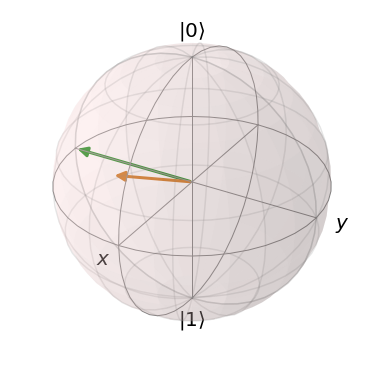

In [18]:
b = Bloch()
b.add_states([result.states[-1], result_white.states[-1]])
b.make_sphere()

The two figures below show the control pulse with and without noise.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2699a135b38>)

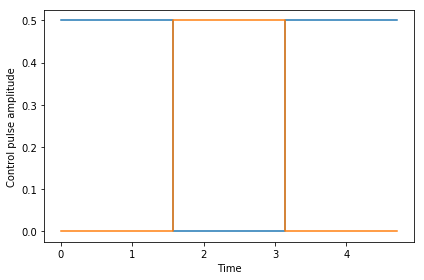

In [19]:
processor_white.plot_pulses(noisy=False)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x269999bb710>)

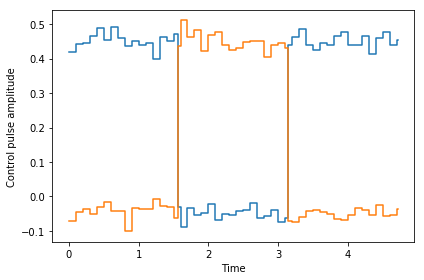

In [20]:
processor_white.plot_pulses(noisy=True)

# Getting the QobjEvo representation
If you define a complicate `Processor` but don't want to run the simulation right now. You can extract a `qutip.QobjEvo` object.

The method `get_unitary_qobjevo` return the noiseless part of the evolution elements. In contrast `get_noisy_qobjevo` return the noisy version, containing noisy `qutip.QobjEvo` and a list of collapse operators.

In [21]:
processor_white.get_unitary_qobjevo()

In [22]:
processor_white.get_noisy_qobjevo()

(<qutip.qobjevo.QobjEvo at 0x269999cd6a0>, [])

The method `get_noisy_coeffs` will return a list of coefficients and the `tlist`, Type of the coefficients depend on the difinition of noise.

In [23]:
coeffs, tlist = processor_white.get_noisy_coeffs()

In [24]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.0.dev0+c50c4bc9
Numpy,1.16.2
SciPy,1.2.1
matplotlib,3.0.3
Cython,0.29.12
Number of CPUs,12
BLAS Info,INTEL MKL
IPython,7.4.0
Python,"3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]"
OS,nt [win32]
